In [37]:
from math import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression #1
from sklearn.svm import SVC                         #2
from sklearn.neighbors import KNeighborsClassifier  #3
from sklearn.ensemble import RandomForestClassifier #4
import xgboost as xgb                               #5

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, classification_report


In [9]:
df = pd.read_csv("tracks_features_popu_100_pourcents.csv", index_col = 0)

In [10]:
# Gestion des colonnes
target = df['popularity']
df = df.drop(columns=['name','album','album_id','artists','artist_ids','release_date',
                      'track_number','disc_number','popularity'])

# Explicit -> int
df['explicit'] = np.where(df['explicit'],1,0)

# Normalisation
scaler = MinMaxScaler()
df[df.columns] = pd.DataFrame(scaler.fit_transform(df), index=df.index)
df.head()

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
id,,,,,,,,,,,,,,,
7lmeHLHBe4nmXzuXc0HDjk,0.0,0.470,0.978,0.636364,0.812104,1.0,0.075026,0.026205,0.000011,0.3560,0.503,0.473644,0.034510,0.8,0.989604
1wsRitfRRtWyEapl0q22o8,1.0,0.599,0.957,1.000000,0.806675,1.0,0.194014,0.012952,0.000071,0.1550,0.489,0.416496,0.033861,0.8,0.989604
1hR0fIFK2qRG3f3RF70pb7,0.0,0.315,0.970,0.636364,0.811732,1.0,0.498452,0.023494,0.000002,0.1220,0.370,0.601561,0.049157,0.8,0.989604
2lbASgTSoDO7MTuLAXlTW0,1.0,0.440,0.967,1.000000,0.805694,0.0,0.244582,0.163655,0.000004,0.1210,0.574,0.388665,0.035089,0.8,0.989604
1MQTmpYOZ6fcMQc56Hdo7T,0.0,0.426,0.929,0.181818,0.792322,1.0,0.072343,0.001627,0.105000,0.0789,0.539,0.510412,0.033762,0.8,0.989604


# 1) Classification sur la popularité

## 1.1) Gestion du seuil et du déséquilibre de classes

In [11]:
seuil = 40

y = np.where(target>seuil, 1,0)
y

array([1, 1, 1, ..., 0, 0, 0])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state = 123)

In [13]:
rus = RandomUnderSampler()

X_ru, y_ru = rus.fit_resample(X_train,y_train)

print('Nouvelle répartition (RUS): \n', pd.Series(y_ru).value_counts(), '\n')

Nouvelle répartition (RUS): 
 0    24660
1    24660
dtype: int64 



## 1.2) Modèles

### a) Model 1 : Regression Logistique

In [14]:
lr = LogisticRegression(max_iter=10000, random_state=22)

param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}

gridcv_lr = GridSearchCV(estimator = lr, param_grid = param_grid_lr, scoring='accuracy', cv=3)

gridcv_lr.fit(X_ru, y_ru)

print('Meilleurs hyperparamètres :', gridcv_lr.best_params_)

Meilleurs hyperparamètres : {'C': 100.0, 'solver': 'lbfgs'}


In [15]:
lr = LogisticRegression(C=100, solver='lbfgs', max_iter=10000, random_state=22)

lr.fit(X_ru, y_ru)
print('Score :', lr.score(X_test, y_test))

y_pred = lr.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Score : 0.6308174664147339


Classe prédite,0,1
Classe réelle,,
0,147118,87526
1,1375,4786


In [16]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77    148493
           1       0.78      0.05      0.10     92312

    accuracy                           0.63    240805
   macro avg       0.70      0.52      0.43    240805
weighted avg       0.68      0.63      0.51    240805



### b) Model 2 : SVC

In [17]:
# svc = SVC(random_state=22)

# param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
#                    {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)}]

# gridcv_svc = GridSearchCV(estimator = svc, param_grid = param_grid_svc, scoring='accuracy', cv=3)

# gridcv_svc.fit(X_ru, y_ru)

# print('Meilleurs hyperparamètres :', gridcv_svc.best_params_)

# # -> Beaucoup trop long 

In [18]:
svc = SVC(random_state=22)

svc.fit(X_ru, y_ru)
print('Score :', svc.score(X_test, y_test))

y_pred = svc.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Score : 0.6315608064616598


Classe prédite,0,1
Classe réelle,,
0,147315,87329
1,1393,4768


In [19]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77    148708
           1       0.77      0.05      0.10     92097

    accuracy                           0.63    240805
   macro avg       0.70      0.52      0.43    240805
weighted avg       0.68      0.63      0.51    240805



### c) Model 3 : KNeighbors

In [20]:
kn = KNeighborsClassifier()

param_grid_kn = {'n_neighbors': np.arange(1,101,1)}

gridcv_kn = GridSearchCV(estimator = kn, param_grid = param_grid_kn, scoring='accuracy', cv=3)

gridcv_kn.fit(X_ru, y_ru)

print(pd.DataFrame.from_dict(gridcv_kn.cv_results_).loc[:,['params','mean_test_score','std_test_score']])

print('\nMeilleurs hyperparamètres :', gridcv_kn.best_params_)

                  params  mean_test_score  std_test_score
0     {'n_neighbors': 1}         0.618694        0.003643
1     {'n_neighbors': 2}         0.608881        0.002323
2     {'n_neighbors': 3}         0.644526        0.004608
3     {'n_neighbors': 4}         0.640876        0.002517
4     {'n_neighbors': 5}         0.658556        0.004347
..                   ...              ...             ...
95   {'n_neighbors': 96}         0.685908        0.004274
96   {'n_neighbors': 97}         0.685949        0.004000
97   {'n_neighbors': 98}         0.685726        0.004623
98   {'n_neighbors': 99}         0.685483        0.004464
99  {'n_neighbors': 100}         0.685401        0.004845

[100 rows x 3 columns]

Meilleurs hyperparamètres : {'n_neighbors': 57}


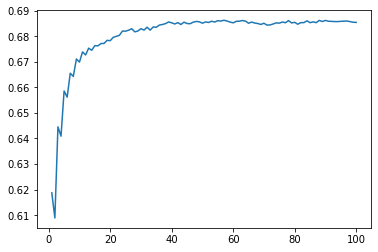

In [25]:
plt.plot(np.arange(1,101,1),pd.DataFrame.from_dict(gridcv_kn.cv_results_).loc[:,['mean_test_score']])
plt.show()

In [26]:
kn = KNeighborsClassifier(n_neighbors = 40)

kn.fit(X_ru, y_ru)
print('Score :', kn.score(X_test, y_test))

y_pred = kn.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Score : 0.6318099707231992


Classe prédite,0,1
Classe réelle,,
0,147496,87148
1,1514,4647


In [27]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77    149010
           1       0.75      0.05      0.09     91795

    accuracy                           0.63    240805
   macro avg       0.69      0.52      0.43    240805
weighted avg       0.68      0.63      0.51    240805



### d) Model 4 : RandomForest

In [28]:
rf = RandomForestClassifier(random_state=22)

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                    'min_samples_leaf': [1, 3, 5],
                    'max_features': ['sqrt', 'log2']}]

gridcv_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, scoring='accuracy', cv=3)

gridcv_rf.fit(X_ru, y_ru)

print('Meilleurs hyperparamètres :', gridcv_rf.best_params_)

Meilleurs hyperparamètres : {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}


In [29]:
rf = RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, n_estimators=1000, random_state=22)

rf.fit(X_ru, y_ru)
print('Score :', rf.score(X_test, y_test))

y_pred = rf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Score : 0.7613047901829281


Classe prédite,0,1
Classe réelle,,
0,178577,56067
1,1412,4749


In [30]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86    179989
           1       0.77      0.08      0.14     60816

    accuracy                           0.76    240805
   macro avg       0.77      0.54      0.50    240805
weighted avg       0.76      0.76      0.68    240805



### e) Model 5 : XGBoost

In [31]:
train = xgb.DMatrix(data = X_ru, label = y_ru)
test  = xgb.DMatrix(data = X_test, label = y_test)

In [32]:
params = {'booster': 'gbtree', 'learning_rate': 0.01, 'objective': 'binary:logistic'}

xgb2 = xgb.train(params=params, dtrain=train, num_boost_round=700, evals=[(train, 'train'), (test, 'eval')], early_stopping_rounds=15)

[22:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.69042	eval-logloss:0.69053
[1]	train-logloss:0.68773	eval-logloss:0.68786
[2]	train-logloss:0.68510	eval-logloss:0.68530
[3]	train-logloss:0.68254	eval-logloss:0.68281
[4]	train-logloss:0.67998	eval-logloss:0.68032
[5]	train-logloss:0.67749	eval-logloss:0.67792
[6]	train-logloss:0.67505	eval-logloss:0.67556
[7]	train-logloss:0.67264	eval-logloss:0.67325
[8]	train-logloss:0.67029	eval-logloss:0.67093
[9]	train-logloss:0.66798	eval-logloss:0.66874
[10]	train-logloss:0.66570	eval-logloss:0.66653
[11]	train-logloss:0.66347	eval-logloss:0.66439
[12]	train-logloss:0.66129	eval-logloss:0.66228
[13]	train-logloss:0.65911	eval-logloss:0.66021
[14]	train-logloss:0.65698	e

[164]	train-logloss:0.52136	eval-logloss:0.53380
[165]	train-logloss:0.52100	eval-logloss:0.53350
[166]	train-logloss:0.52064	eval-logloss:0.53323
[167]	train-logloss:0.52031	eval-logloss:0.53295
[168]	train-logloss:0.51999	eval-logloss:0.53272
[169]	train-logloss:0.51964	eval-logloss:0.53246
[170]	train-logloss:0.51929	eval-logloss:0.53220
[171]	train-logloss:0.51899	eval-logloss:0.53195
[172]	train-logloss:0.51868	eval-logloss:0.53173
[173]	train-logloss:0.51834	eval-logloss:0.53148
[174]	train-logloss:0.51804	eval-logloss:0.53126
[175]	train-logloss:0.51774	eval-logloss:0.53100
[176]	train-logloss:0.51744	eval-logloss:0.53078
[177]	train-logloss:0.51712	eval-logloss:0.53055
[178]	train-logloss:0.51680	eval-logloss:0.53032
[179]	train-logloss:0.51650	eval-logloss:0.53007
[180]	train-logloss:0.51622	eval-logloss:0.52985
[181]	train-logloss:0.51593	eval-logloss:0.52965
[182]	train-logloss:0.51566	eval-logloss:0.52944
[183]	train-logloss:0.51534	eval-logloss:0.52920
[184]	train-logloss:

[332]	train-logloss:0.48742	eval-logloss:0.51079
[333]	train-logloss:0.48728	eval-logloss:0.51071
[334]	train-logloss:0.48715	eval-logloss:0.51063
[335]	train-logloss:0.48704	eval-logloss:0.51058
[336]	train-logloss:0.48692	eval-logloss:0.51051
[337]	train-logloss:0.48680	eval-logloss:0.51046
[338]	train-logloss:0.48667	eval-logloss:0.51040
[339]	train-logloss:0.48654	eval-logloss:0.51033
[340]	train-logloss:0.48644	eval-logloss:0.51027
[341]	train-logloss:0.48633	eval-logloss:0.51022
[342]	train-logloss:0.48622	eval-logloss:0.51016
[343]	train-logloss:0.48609	eval-logloss:0.51009
[344]	train-logloss:0.48598	eval-logloss:0.51004
[345]	train-logloss:0.48587	eval-logloss:0.50999
[346]	train-logloss:0.48574	eval-logloss:0.50992
[347]	train-logloss:0.48564	eval-logloss:0.50987
[348]	train-logloss:0.48553	eval-logloss:0.50980
[349]	train-logloss:0.48541	eval-logloss:0.50976
[350]	train-logloss:0.48529	eval-logloss:0.50970
[351]	train-logloss:0.48519	eval-logloss:0.50965
[352]	train-logloss:

[500]	train-logloss:0.47401	eval-logloss:0.50436
[501]	train-logloss:0.47397	eval-logloss:0.50435
[502]	train-logloss:0.47392	eval-logloss:0.50431
[503]	train-logloss:0.47384	eval-logloss:0.50429
[504]	train-logloss:0.47375	eval-logloss:0.50426
[505]	train-logloss:0.47371	eval-logloss:0.50423
[506]	train-logloss:0.47365	eval-logloss:0.50421
[507]	train-logloss:0.47362	eval-logloss:0.50421
[508]	train-logloss:0.47354	eval-logloss:0.50418
[509]	train-logloss:0.47350	eval-logloss:0.50417
[510]	train-logloss:0.47348	eval-logloss:0.50416
[511]	train-logloss:0.47340	eval-logloss:0.50414
[512]	train-logloss:0.47332	eval-logloss:0.50410
[513]	train-logloss:0.47326	eval-logloss:0.50408
[514]	train-logloss:0.47322	eval-logloss:0.50406
[515]	train-logloss:0.47315	eval-logloss:0.50402
[516]	train-logloss:0.47309	eval-logloss:0.50400
[517]	train-logloss:0.47305	eval-logloss:0.50397
[518]	train-logloss:0.47300	eval-logloss:0.50395
[519]	train-logloss:0.47293	eval-logloss:0.50393
[520]	train-logloss:

[668]	train-logloss:0.46619	eval-logloss:0.50179
[669]	train-logloss:0.46612	eval-logloss:0.50177
[670]	train-logloss:0.46611	eval-logloss:0.50177
[671]	train-logloss:0.46607	eval-logloss:0.50175
[672]	train-logloss:0.46603	eval-logloss:0.50175
[673]	train-logloss:0.46597	eval-logloss:0.50173
[674]	train-logloss:0.46595	eval-logloss:0.50173
[675]	train-logloss:0.46589	eval-logloss:0.50171
[676]	train-logloss:0.46585	eval-logloss:0.50168
[677]	train-logloss:0.46582	eval-logloss:0.50168
[678]	train-logloss:0.46579	eval-logloss:0.50167
[679]	train-logloss:0.46578	eval-logloss:0.50167
[680]	train-logloss:0.46571	eval-logloss:0.50165
[681]	train-logloss:0.46567	eval-logloss:0.50165
[682]	train-logloss:0.46566	eval-logloss:0.50165
[683]	train-logloss:0.46563	eval-logloss:0.50165
[684]	train-logloss:0.46559	eval-logloss:0.50164
[685]	train-logloss:0.46552	eval-logloss:0.50163
[686]	train-logloss:0.46546	eval-logloss:0.50161
[687]	train-logloss:0.46543	eval-logloss:0.50159
[688]	train-logloss:

In [33]:
preds = xgb2.predict(test)
xgbpreds = pd.Series(np.where(preds > 0.5, 1, 0))

cm = pd.crosstab(pd.Series(y_test), xgbpreds, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,0,1
Classe réelle,,
0,176766,57878
1,1386,4775


In [34]:
print(classification_report(y_test, xgbpreds))

              precision    recall  f1-score   support

           0       0.99      0.75      0.86    234644
           1       0.08      0.78      0.14      6161

    accuracy                           0.75    240805
   macro avg       0.53      0.76      0.50    240805
weighted avg       0.97      0.75      0.84    240805



## 1.3) Résultats

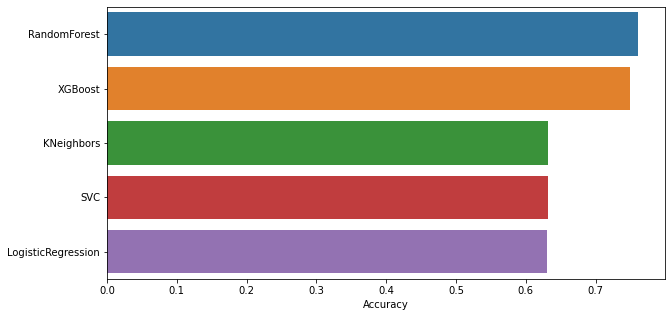

In [35]:
algos = ['RandomForest','XGBoost','KNeighbors','SVC','LogisticRegression']
scores = [0.7613047901829281,0.75,0.6318099707231992,0.6315608064616598,0.6308174664147339]

plt.figure(figsize=(10,5))
sns.barplot(y=algos, x=scores)
plt.xlabel('Accuracy');

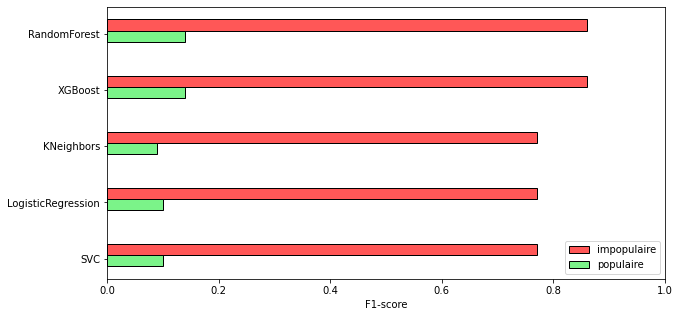

In [38]:
plt.figure(figsize=(10,5))

algorithmes = ['SVC','LogisticRegression','KNeighbors','XGBoost','RandomForest']
sous_categories = ['impopulaire', 'populaire']

f1_score_impopulaire = [0.77, 0.77, 0.77, 0.86, 0.86]
f1_score_populaire   = [0.10, 0.10, 0.09, 0.14, 0.14]

nb_categories = len(algorithmes)

largeur_barre = floor(1*10/nb_categories)/10

x1 = range(len(f1_score_impopulaire))

x2 = [i + largeur_barre for i in x1]

plt.barh(x2, f1_score_impopulaire, height = largeur_barre, color = '#ff5757', edgecolor = 'black', linewidth = 1)
plt.barh(x1, f1_score_populaire, height = largeur_barre, color = '#7bf389', edgecolor = 'black', linewidth = 1)

plt.yticks([r + largeur_barre / nb_categories for r in range(nb_categories)], algorithmes)
plt.xlim([0,1])
plt.xlabel('F1-score')
plt.legend(sous_categories,loc='lower right')
plt.show()

# 2) Classification sur les vues de YouTube

## 2.1) Import du dataset

In [39]:
df_yt = pd.read_csv('tracks_features_max_popu+YT_FULL.csv', index_col = 0)
print('shape initiale :', df_yt.shape)
df_yt = df_yt[df_yt['views_YT'] > 0]
print('shape sans les zeros :', df_yt.shape) #Pertes des musiques qui n'ont pas été trouvé sur Youtube 
                                             #(cela ne veut pas dire qu'elles n'y sont pas)

df_yt = df_yt.drop(columns=['name', 'album', 'album_id', 'artists', 'artist_ids', 'track_number', 'disc_number','release_date'])
df_yt['explicit'] = np.where(df_yt['explicit'],1,0)

shape initiale : (12436, 26)
shape sans les zeros : (9866, 26)


On ne prend que les musiques dont le nb de vues dépasse 10 000 car ce sont des outliers (on a sélectionner que des musiques populaires donc si on a trouver qu'elles n'avait que 10, 1000 ou 10000 vues c'est probablement que nous n'avons pas scrapper le bon lien Youtube)

In [40]:
df_yt_reduit = df_yt[df_yt['views_YT'] >= 1e4]
df_yt_reduit

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,popularity,views_YT,likes_YT
id,,,,,,,,,,,,,,,,,,
7lmeHLHBe4nmXzuXc0HDjk,0,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.5030,117.906,210133,4.0,1999,65,17375832,132343
1wsRitfRRtWyEapl0q22o8,1,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.4890,103.680,206200,4.0,1999,69,7325119,100441
1hR0fIFK2qRG3f3RF70pb7,0,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.3700,149.749,298893,4.0,1999,55,268060,3966
1MQTmpYOZ6fcMQc56Hdo7T,0,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.5390,127.059,205600,4.0,1999,66,8532399,110795
2LXPNLSMAauNJfnC58lSqY,0,0.298,0.848,2,-5.947,1,0.0727,0.05380,0.001520,0.2010,0.1940,148.282,280960,4.0,1999,53,3708514,16021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67ACYA3UI6QMNtHX6b34wX,1,0.643,0.727,1,-5.506,1,0.0389,0.04390,0.000000,0.1230,0.2950,90.019,162299,4.0,2020,72,41719257,650590
09WAnxdBuebQopKhJT3oZS,0,0.430,0.412,2,-5.372,1,0.0281,0.20000,0.000000,0.3240,0.0508,90.872,157673,4.0,2020,68,19563803,503040
3KJ3opyV29269SXkPrc19l,1,0.636,0.656,2,-5.542,0,0.0676,0.45100,0.000008,0.2870,0.4390,171.918,151506,4.0,2020,83,67869252,783460


On définit les classes a prédire :

- Classe 0 = <1M
- Classe 1 = (1M,10M)
- Classe 2 = (10M,100M)
- Classe 3 = (>100M)

In [41]:
df_yt_reduit['classe'] = np.where(df_yt_reduit['views_YT'] < 1e6, 0,
                                 np.where(df_yt_reduit['views_YT'] < 1e7, 1, 
                                         np.where(df_yt_reduit['views_YT'] < 1e8, 2,3)))

<ipython-input-41-643444db30b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yt_reduit['classe'] = np.where(df_yt_reduit['views_YT'] < 1e6, 0,


In [42]:
# Gestion des colonnes 
target = df_yt_reduit['classe']
df_yt_reduit = df_yt_reduit.drop(columns=['popularity', 'views_YT', 'likes_YT','classe'])

# Normalisation
scaler = MinMaxScaler()
df_yt_reduit[df_yt_reduit.columns] = pd.DataFrame(scaler.fit_transform(df_yt_reduit), index=df_yt_reduit.index)
df_yt_reduit.head()

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
id,,,,,,,,,,,,,,,
7lmeHLHBe4nmXzuXc0HDjk,0.0,0.446640,0.980919,0.636364,0.875880,1.0,0.053732,0.026203,0.000011,0.352821,0.493447,0.441523,0.195053,0.75,0.776596
1wsRitfRRtWyEapl0q22o8,1.0,0.588274,0.959830,1.000000,0.867566,1.0,0.177392,0.012950,0.000072,0.146667,0.478885,0.363778,0.190736,0.75,0.776596
1hR0fIFK2qRG3f3RF70pb7,0.0,0.276460,0.972885,0.636364,0.875310,1.0,0.493779,0.023493,0.000002,0.112821,0.355107,0.615542,0.292473,0.75,0.776596
1MQTmpYOZ6fcMQc56Hdo7T,0.0,0.398331,0.931711,0.181818,0.845584,1.0,0.050944,0.001625,0.107034,0.068615,0.530892,0.491543,0.190078,0.75,0.776596
2LXPNLSMAauNJfnC58lSqY,0.0,0.257795,0.850367,0.181818,0.863397,1.0,0.053732,0.054015,0.001549,0.193846,0.172041,0.607525,0.272790,0.75,0.776596


## 2.2) Déséquilibre de classes

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df_yt_reduit, target, test_size=0.2, random_state = 123)

In [44]:
ros = RandomOverSampler()

X_ro, y_ro = ros.fit_resample(X_train,y_train)

print('Nouvelle répartition (ROS): \n', pd.Series(y_ro).value_counts(), '\n')

Nouvelle répartition (ROS): 
 0    2952
1    2952
2    2952
3    2952
Name: classe, dtype: int64 



## 2.3) Modèles

### a) Model 1 : Regression Logistique

In [45]:
lr = LogisticRegression(max_iter=10000, random_state=22)

param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}

gridcv_lr = GridSearchCV(estimator = lr, param_grid = param_grid_lr, scoring='accuracy', cv=3)

gridcv_lr.fit(X_ro, y_ro)

print('Meilleurs hyperparamètres :', gridcv_lr.best_params_)

Meilleurs hyperparamètres : {'C': 100.0, 'solver': 'liblinear'}


In [46]:
lr = LogisticRegression(C=100.0, solver='liblinear', max_iter=10000, random_state=22)

lr.fit(X_ro, y_ro)
print('Score :', lr.score(X_test, y_test))

y_pred = lr.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Score : 0.2826982492276004


Classe prédite,0,1,2,3
Classe réelle,,,,
0,125,63,33,108
1,216,191,90,241
2,158,142,105,247
3,30,32,33,128


In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.38      0.29       329
           1       0.45      0.26      0.33       738
           2       0.40      0.16      0.23       652
           3       0.18      0.57      0.27       223

    accuracy                           0.28      1942
   macro avg       0.32      0.34      0.28      1942
weighted avg       0.36      0.28      0.28      1942



### b) Model 2 : SVC

In [48]:
# svc = SVC(random_state=22)

# param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
#                    {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)}]

# gridcv_svc = GridSearchCV(estimator = svc, param_grid = param_grid_svc, scoring='accuracy', cv=3)

# gridcv_svc.fit(X_ro, y_ro)

# print('Meilleurs hyperparamètres :', gridcv_svc.best_params_)

# Toujours aussi long 

In [49]:
svc = SVC(random_state=22)

svc.fit(X_ro, y_ro)
print('Score :', svc.score(X_test, y_test))

y_pred = svc.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Score : 0.3094747682801236


Classe prédite,0,1,2,3
Classe réelle,,,,
0,102,65,63,99
1,173,176,176,213
2,107,136,198,211
3,18,24,56,125


In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.31      0.28       329
           1       0.44      0.24      0.31       738
           2       0.40      0.30      0.35       652
           3       0.19      0.56      0.29       223

    accuracy                           0.31      1942
   macro avg       0.32      0.35      0.31      1942
weighted avg       0.37      0.31      0.31      1942



### c) Model 3 : KNeighbors

In [51]:
kn = KNeighborsClassifier()

param_grid_kn = {'n_neighbors': np.arange(1,101,1)}

gridcv_kn = GridSearchCV(estimator = kn, param_grid = param_grid_kn, scoring='accuracy', cv=3)

gridcv_kn.fit(X_ro, y_ro)

print(pd.DataFrame.from_dict(gridcv_kn.cv_results_).loc[:,['params','mean_test_score','std_test_score']])

print('\nMeilleurs hyperparamètres :', gridcv_kn.best_params_)

                  params  mean_test_score  std_test_score
0     {'n_neighbors': 1}         0.672849        0.034775
1     {'n_neighbors': 2}         0.596714        0.018369
2     {'n_neighbors': 3}         0.543699        0.015525
3     {'n_neighbors': 4}         0.498984        0.013653
4     {'n_neighbors': 5}         0.474509        0.020018
..                   ...              ...             ...
95   {'n_neighbors': 96}         0.354251        0.008488
96   {'n_neighbors': 97}         0.353066        0.008112
97   {'n_neighbors': 98}         0.351372        0.008419
98   {'n_neighbors': 99}         0.351203        0.006327
99  {'n_neighbors': 100}         0.351033        0.005100

[100 rows x 3 columns]

Meilleurs hyperparamètres : {'n_neighbors': 1}


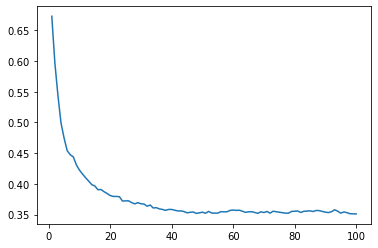

In [52]:
plt.plot(np.arange(1,101,1),pd.DataFrame.from_dict(gridcv_kn.cv_results_).loc[:,['mean_test_score']])
plt.show()

In [53]:
kn = KNeighborsClassifier(n_neighbors = 1)

kn.fit(X_ro, y_ro)
print('Score :', kn.score(X_test, y_test))

y_pred = kn.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Score : 0.398043254376931


Classe prédite,0,1,2,3
Classe réelle,,,,
0,74,135,96,24
1,125,329,220,64
2,78,211,301,62
3,26,63,65,69


In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.22      0.23       329
           1       0.45      0.45      0.45       738
           2       0.44      0.46      0.45       652
           3       0.32      0.31      0.31       223

    accuracy                           0.40      1942
   macro avg       0.36      0.36      0.36      1942
weighted avg       0.40      0.40      0.40      1942



### d) Model 4 : RandomForest

In [55]:
rf = RandomForestClassifier(random_state=22)

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                    'min_samples_leaf': [1, 3, 5],
                    'max_features': ['sqrt', 'log2']}]

gridcv_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, scoring='accuracy', cv=3)

gridcv_rf.fit(X_ro, y_ro)

print('Meilleurs hyperparamètres :', gridcv_rf.best_params_)

Meilleurs hyperparamètres : {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}


In [56]:
rf = RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, n_estimators=500, random_state=22)

rf.fit(X_ro, y_ro)
print('Score :', rf.score(X_test, y_test))

y_pred = rf.predict(X_test)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Score : 0.44799176107106076


Classe prédite,0,1,2,3
Classe réelle,,,,
0,62,163,96,8
1,77,421,228,12
2,30,277,327,18
3,5,49,109,60


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.19      0.25       329
           1       0.46      0.57      0.51       738
           2       0.43      0.50      0.46       652
           3       0.61      0.27      0.37       223

    accuracy                           0.45      1942
   macro avg       0.47      0.38      0.40      1942
weighted avg       0.45      0.45      0.43      1942



In [58]:
n = len(y_test)

good_pred = 0
bad_pred_1 = 0
bad_pred_2 = 0
bad_pred_3 = 0

for i in range(n):
    diff = abs(y_test[i] - y_pred[i])
    if   diff == 0: good_pred  += 1
    elif diff == 1: bad_pred_1 += 1 
    elif diff == 2: bad_pred_2 += 1      
    else          : bad_pred_3 += 1

print('good_pred/n', good_pred/n)
print('bad_pred_1/n', bad_pred_1/n)
print('bad_pred_2/n', bad_pred_2/n)
print('bad_pred_3/n', bad_pred_3/n)

good_pred/n 0.44799176107106076
bad_pred_1/n 0.4490216271884655
bad_pred_2/n 0.09629248197734294
bad_pred_3/n 0.006694129763130793


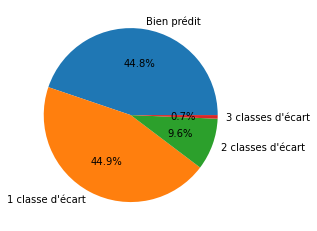

In [59]:
plt.pie([good_pred/n, bad_pred_1/n, bad_pred_2/n, bad_pred_3/n], labels=['Bien prédit',"1 classe d'écart",
                                                                         "2 classes d'écart","3 classes d'écart"],
        autopct='%.1f%%');

### e) Model 5 : XGBoost

In [60]:
train = xgb.DMatrix(data = X_ro, label = y_ro)
test  = xgb.DMatrix(data = X_test, label = y_test)

In [61]:
params = {'booster': 'gbtree', 'learning_rate': 0.05, 'objective': 'multi:softprob', 'num_class': 4}

xgb2 = xgb.train(params=params, dtrain=train, num_boost_round=700, evals=[(train, 'train'), (test, 'eval')], early_stopping_rounds=15)

[23:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.37422	eval-mlogloss:1.38105
[1]	train-mlogloss:1.36303	eval-mlogloss:1.37636
[2]	train-mlogloss:1.35271	eval-mlogloss:1.37228
[3]	train-mlogloss:1.34256	eval-mlogloss:1.36831
[4]	train-mlogloss:1.33344	eval-mlogloss:1.36522
[5]	train-mlogloss:1.32440	eval-mlogloss:1.36202
[6]	train-mlogloss:1.31514	eval-mlogloss:1.35898
[7]	train-mlogloss:1.30594	eval-mlogloss:1.35604
[8]	train-mlogloss:1.29748	eval-mlogloss:1.35351
[9]	train-mlogloss:1.28884	eval-mlogloss:1.35080
[10]	train-mlogloss:1.28090	eval-mlogloss:1.34827
[11]	train-mlogloss:1.27360	eval-mlogloss:1.34596
[12]	train-mlogloss:1.26564	eval-mlogloss:1.34326
[13]	train-mlogloss:1.25785	eval-mlogloss:1.34083

[157]	train-mlogloss:0.86741	eval-mlogloss:1.27793
[158]	train-mlogloss:0.86682	eval-mlogloss:1.27801
[159]	train-mlogloss:0.86563	eval-mlogloss:1.27770
[160]	train-mlogloss:0.86492	eval-mlogloss:1.27802
[161]	train-mlogloss:0.86369	eval-mlogloss:1.27814
[162]	train-mlogloss:0.86249	eval-mlogloss:1.27809
[163]	train-mlogloss:0.86124	eval-mlogloss:1.27816
[164]	train-mlogloss:0.86031	eval-mlogloss:1.27831
[165]	train-mlogloss:0.85860	eval-mlogloss:1.27821
[166]	train-mlogloss:0.85711	eval-mlogloss:1.27820
[167]	train-mlogloss:0.85622	eval-mlogloss:1.27796
[168]	train-mlogloss:0.85496	eval-mlogloss:1.27791
[169]	train-mlogloss:0.85425	eval-mlogloss:1.27790
[170]	train-mlogloss:0.85254	eval-mlogloss:1.27779
[171]	train-mlogloss:0.85186	eval-mlogloss:1.27787
[172]	train-mlogloss:0.85015	eval-mlogloss:1.27782
[173]	train-mlogloss:0.84849	eval-mlogloss:1.27797
[174]	train-mlogloss:0.84685	eval-mlogloss:1.27749
[175]	train-mlogloss:0.84590	eval-mlogloss:1.27746
[176]	train-mlogloss:0.84498	ev

In [62]:
preds = xgb2.predict(test)
xgbpreds = preds.argmax(axis=1)
xgbpreds

cm = pd.crosstab(y_test, xgbpreds, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,0,1,2,3
Classe réelle,,,,
0,99,117,74,39
1,129,311,202,96
2,79,199,247,127
3,16,37,66,104


In [63]:
print(classification_report(y_test, xgbpreds))

              precision    recall  f1-score   support

           0       0.31      0.30      0.30       329
           1       0.47      0.42      0.44       738
           2       0.42      0.38      0.40       652
           3       0.28      0.47      0.35       223

    accuracy                           0.39      1942
   macro avg       0.37      0.39      0.37      1942
weighted avg       0.40      0.39      0.39      1942



## 2.4) Résultats

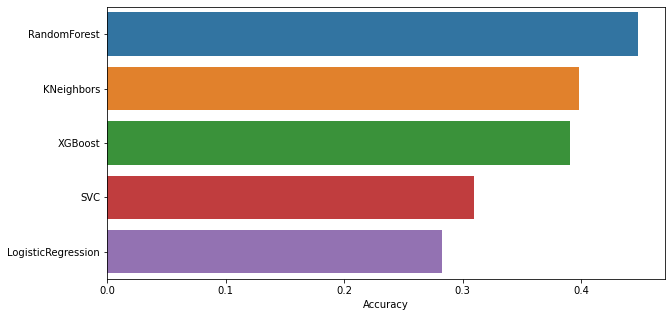

In [66]:
algos = ['RandomForest','KNeighbors','XGBoost','SVC','LogisticRegression']
scores = [0.44799176107106076,0.398043254376931,0.39,0.3094747682801236,0.2826982492276004]

plt.figure(figsize=(10,5))
sns.barplot(y=algos, x=scores)
plt.xlabel('Accuracy');

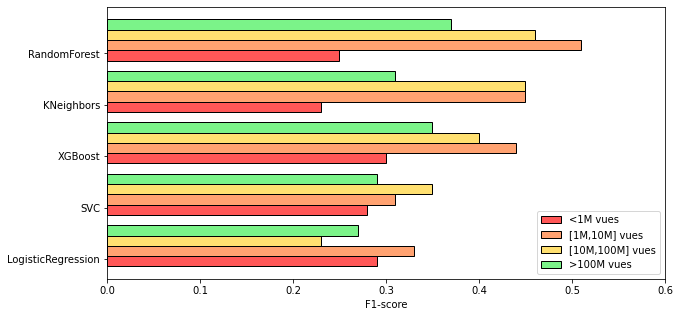

In [67]:
plt.figure(figsize=(10,5))

algorithmes = ['LogisticRegression','SVC','XGBoost','KNeighbors','RandomForest']
sous_categories = ['<1M vues', '[1M,10M] vues','[10M,100M] vues','>100M vues']

y1 = [0.29, 0.28, 0.30, 0.23, 0.25] #f1-score classe 0 
y2 = [0.33, 0.31, 0.44, 0.45, 0.51] #f1-score classe 1 
y3 = [0.23, 0.35, 0.40, 0.45, 0.46] #f1-score classe 2 
y4 = [0.27, 0.29, 0.35, 0.31, 0.37] #f1-score classe 3 

nb_categories = len(algorithmes)

largeur_barre = floor(1*10/nb_categories)/10

x1 = range(len(y1))
x2 = [i + largeur_barre for i in x1]
x3 = [i + 2*largeur_barre for i in x1]
x4 = [i + 3*largeur_barre for i in x1]

plt.barh(x1, y1, height = largeur_barre, color = '#ff5757', edgecolor = 'black', linewidth = 1)
plt.barh(x2, y2, height = largeur_barre, color = '#ffa271', edgecolor = 'black', linewidth = 1)
plt.barh(x3, y3, height = largeur_barre, color = '#ffe071', edgecolor = 'black', linewidth = 1)
plt.barh(x4, y4, height = largeur_barre, color = '#7bf389', edgecolor = 'black', linewidth = 1)

plt.yticks([r + largeur_barre / nb_categories for r in range(nb_categories)], algorithmes)
plt.xlabel('F1-score')
plt.xlim([0,0.6])
plt.legend(sous_categories,loc='lower right')
plt.show()